<a href="https://colab.research.google.com/github/DataMinati/100-Super-Notebooks/blob/main/Ensembled_Diabetes_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!pip install pycaret[full]
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.9/286.9 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Before we get started, let's take a quick look at datasets.

**The objective of the dataset**

> This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**The Pima Indian Diabetes data set consists of:**

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0

--------------------------------------------------------------------------------------------------------------------------
# Load Libraries

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings(action='ignore')

# Defining Utility functions

In [24]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

# Reading and Checking data

In [25]:
diabetes_df = pd.read_csv("/content/diabetes.csv")
diabetes_df.head().T.style.set_properties(**{'background-color': 'grey',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
Pregnancies,6.000000,1.000000,8.000000,1.000000,0.000000
Glucose,148.000000,85.000000,183.000000,89.000000,137.000000
BloodPressure,72.000000,66.000000,64.000000,66.000000,40.000000
SkinThickness,35.000000,29.000000,0.000000,23.000000,35.000000
Insulin,0.000000,0.000000,0.000000,94.000000,168.000000
BMI,33.600000,26.600000,23.300000,28.100000,43.100000
DiabetesPedigreeFunction,0.627000,0.351000,0.672000,0.167000,2.288000
Age,50.000000,31.000000,32.000000,21.000000,33.000000
Outcome,1.000000,0.000000,1.000000,0.000000,1.000000


DiabetesPedigreeFunction has a long name. Change to DPF.

In [26]:
diabetes_df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

--------------------------------------------
# EDA

## Checking Missing Values and Data type
Let's check if there are missing values.

<Axes: >

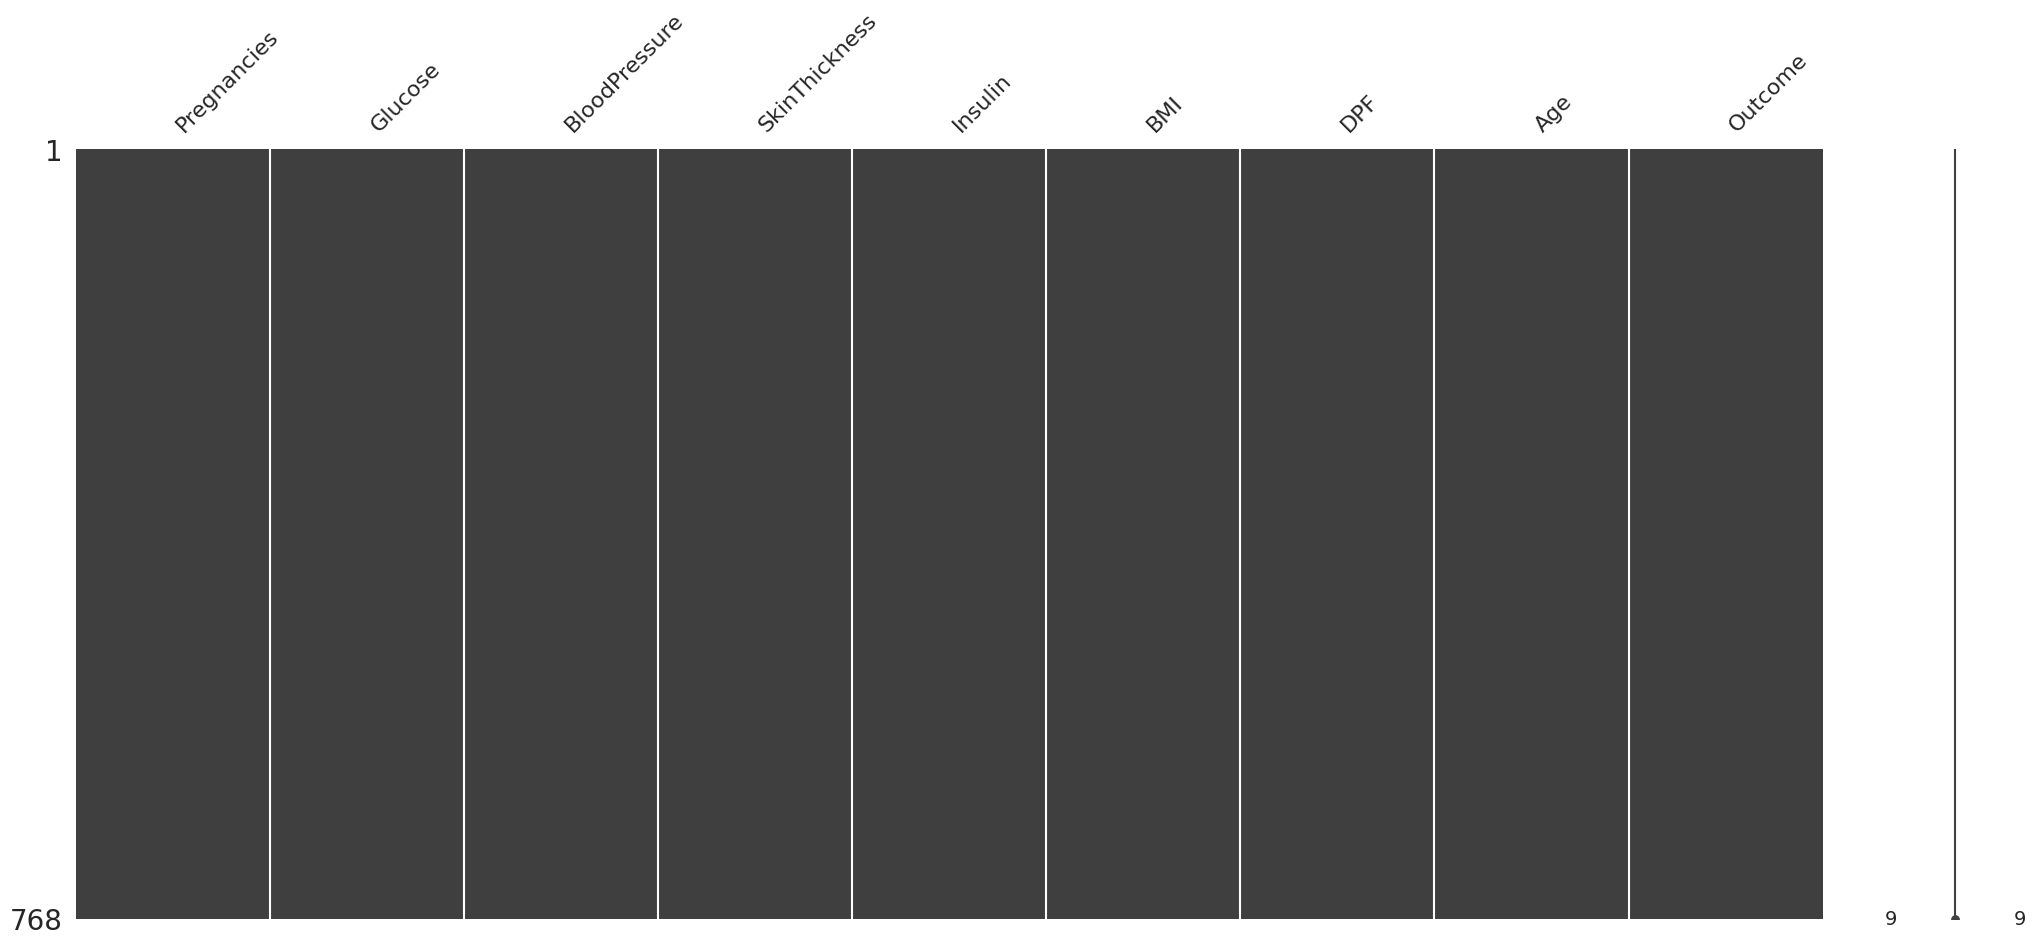

In [27]:
import missingno as msno
msno.matrix(diabetes_df)

**Good!. There is no missing value and all features type are number. Therefore, there is no need to preprocess for missing values.**

## Checking Target Imbalance

In [28]:
colors = ['gold', 'mediumturquoise']
labels = ['0','1']
values = diabetes_df['Outcome'].value_counts()/diabetes_df['Outcome'].shape[0]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Outcome")
fig.show()

OK! The target is well balanced.

## Checking Statistics

In [29]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

diabetes_df.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Among the features, there are many features whose min() value is 0. Let's check out more of these features.**

--------------------------------------------------
# Checking and Removing Outliers

In [30]:
feature_names = [cname for cname in diabetes_df.loc[:,:'Age'].columns]

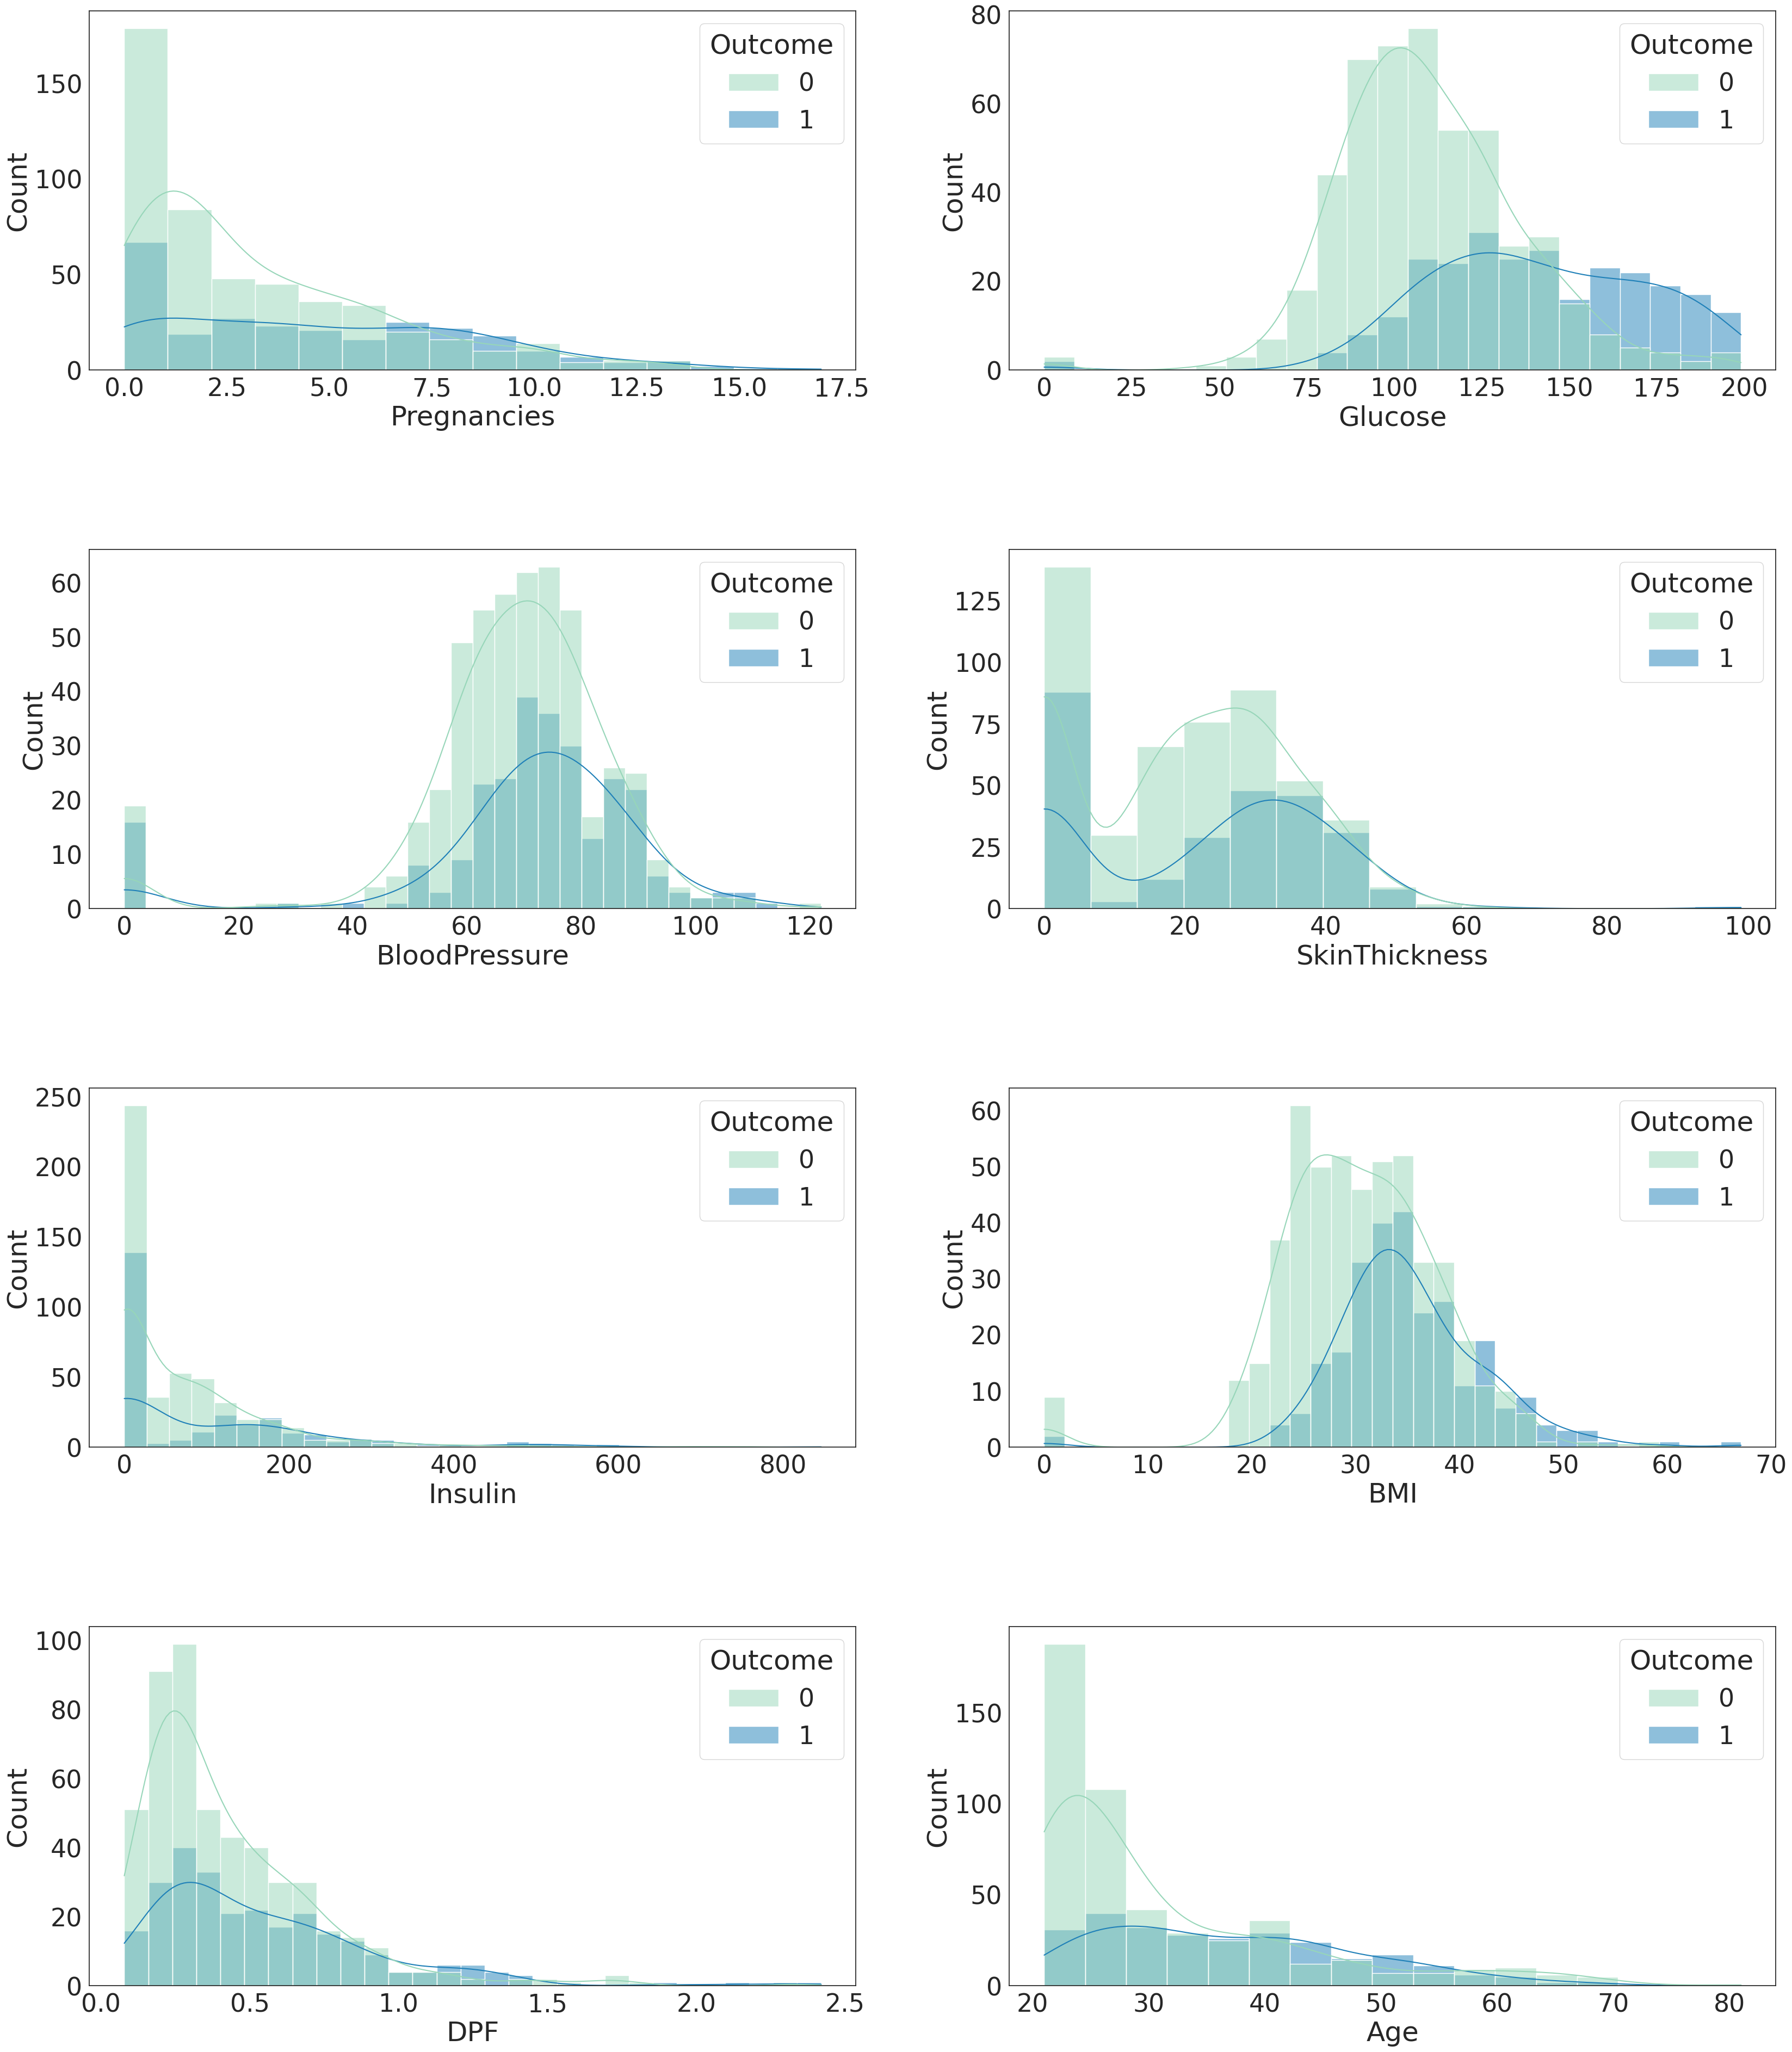

In [31]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Looking at the pictures above, it would be good to change the zero value of each feature to another value.
First, let's calculate the proportion of zero values in each feature.

In [32]:
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = diabetes_df['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_df[diabetes_df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies 0 number of cases 111, percent is 14.45 %
Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


As shown above, the ratio of the value of zero in the SkinThickness and Insulin features seems to be high. Let's change the corresponding values to the mean value of each feature.

> However, a zero value may be meaningful to the corresponding feature. If you have an expert with expertise in diabetes, you will be able to confirm that your decision is correct.
However, since there is no such domain knowledge or friends, we will first replace the corresponding value with the mean value.

In [33]:
diabetes_mean = diabetes_df[zero_features].mean()
diabetes_df[zero_features]=diabetes_df[zero_features].replace(0, diabetes_mean)

If we remove the zero value of each feature, we have a distribution similar to the normal distribution. Therefore, perform linear scaling and standard scaling.

In [34]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df.iloc[:,-1]

-------------------------------------------
# Scaling

Although the zero values of each feature are converted to mean values, some features have a one-sided shape. Therefore, we decided to perform nonlinear scaling, and decided to use the QuantileTransformer that changes the distribution closest to the normal distribution.

In [35]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_scaled = scaler.fit_transform(X)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

X_train.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,4.315407,121.709154,72.144653,26.341978,118.600098,32.315027,0.468618,32.921875
std,2.916151,30.080570,12.113756,9.158041,94.570101,6.878494,0.339325,11.507539
min,1.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,2.000000,100.000000,64.000000,20.536458,79.799479,27.275000,0.240000,24.000000
50%,3.845052,118.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000
75%,6.000000,138.250000,80.000000,32.000000,127.500000,36.325000,0.612250,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


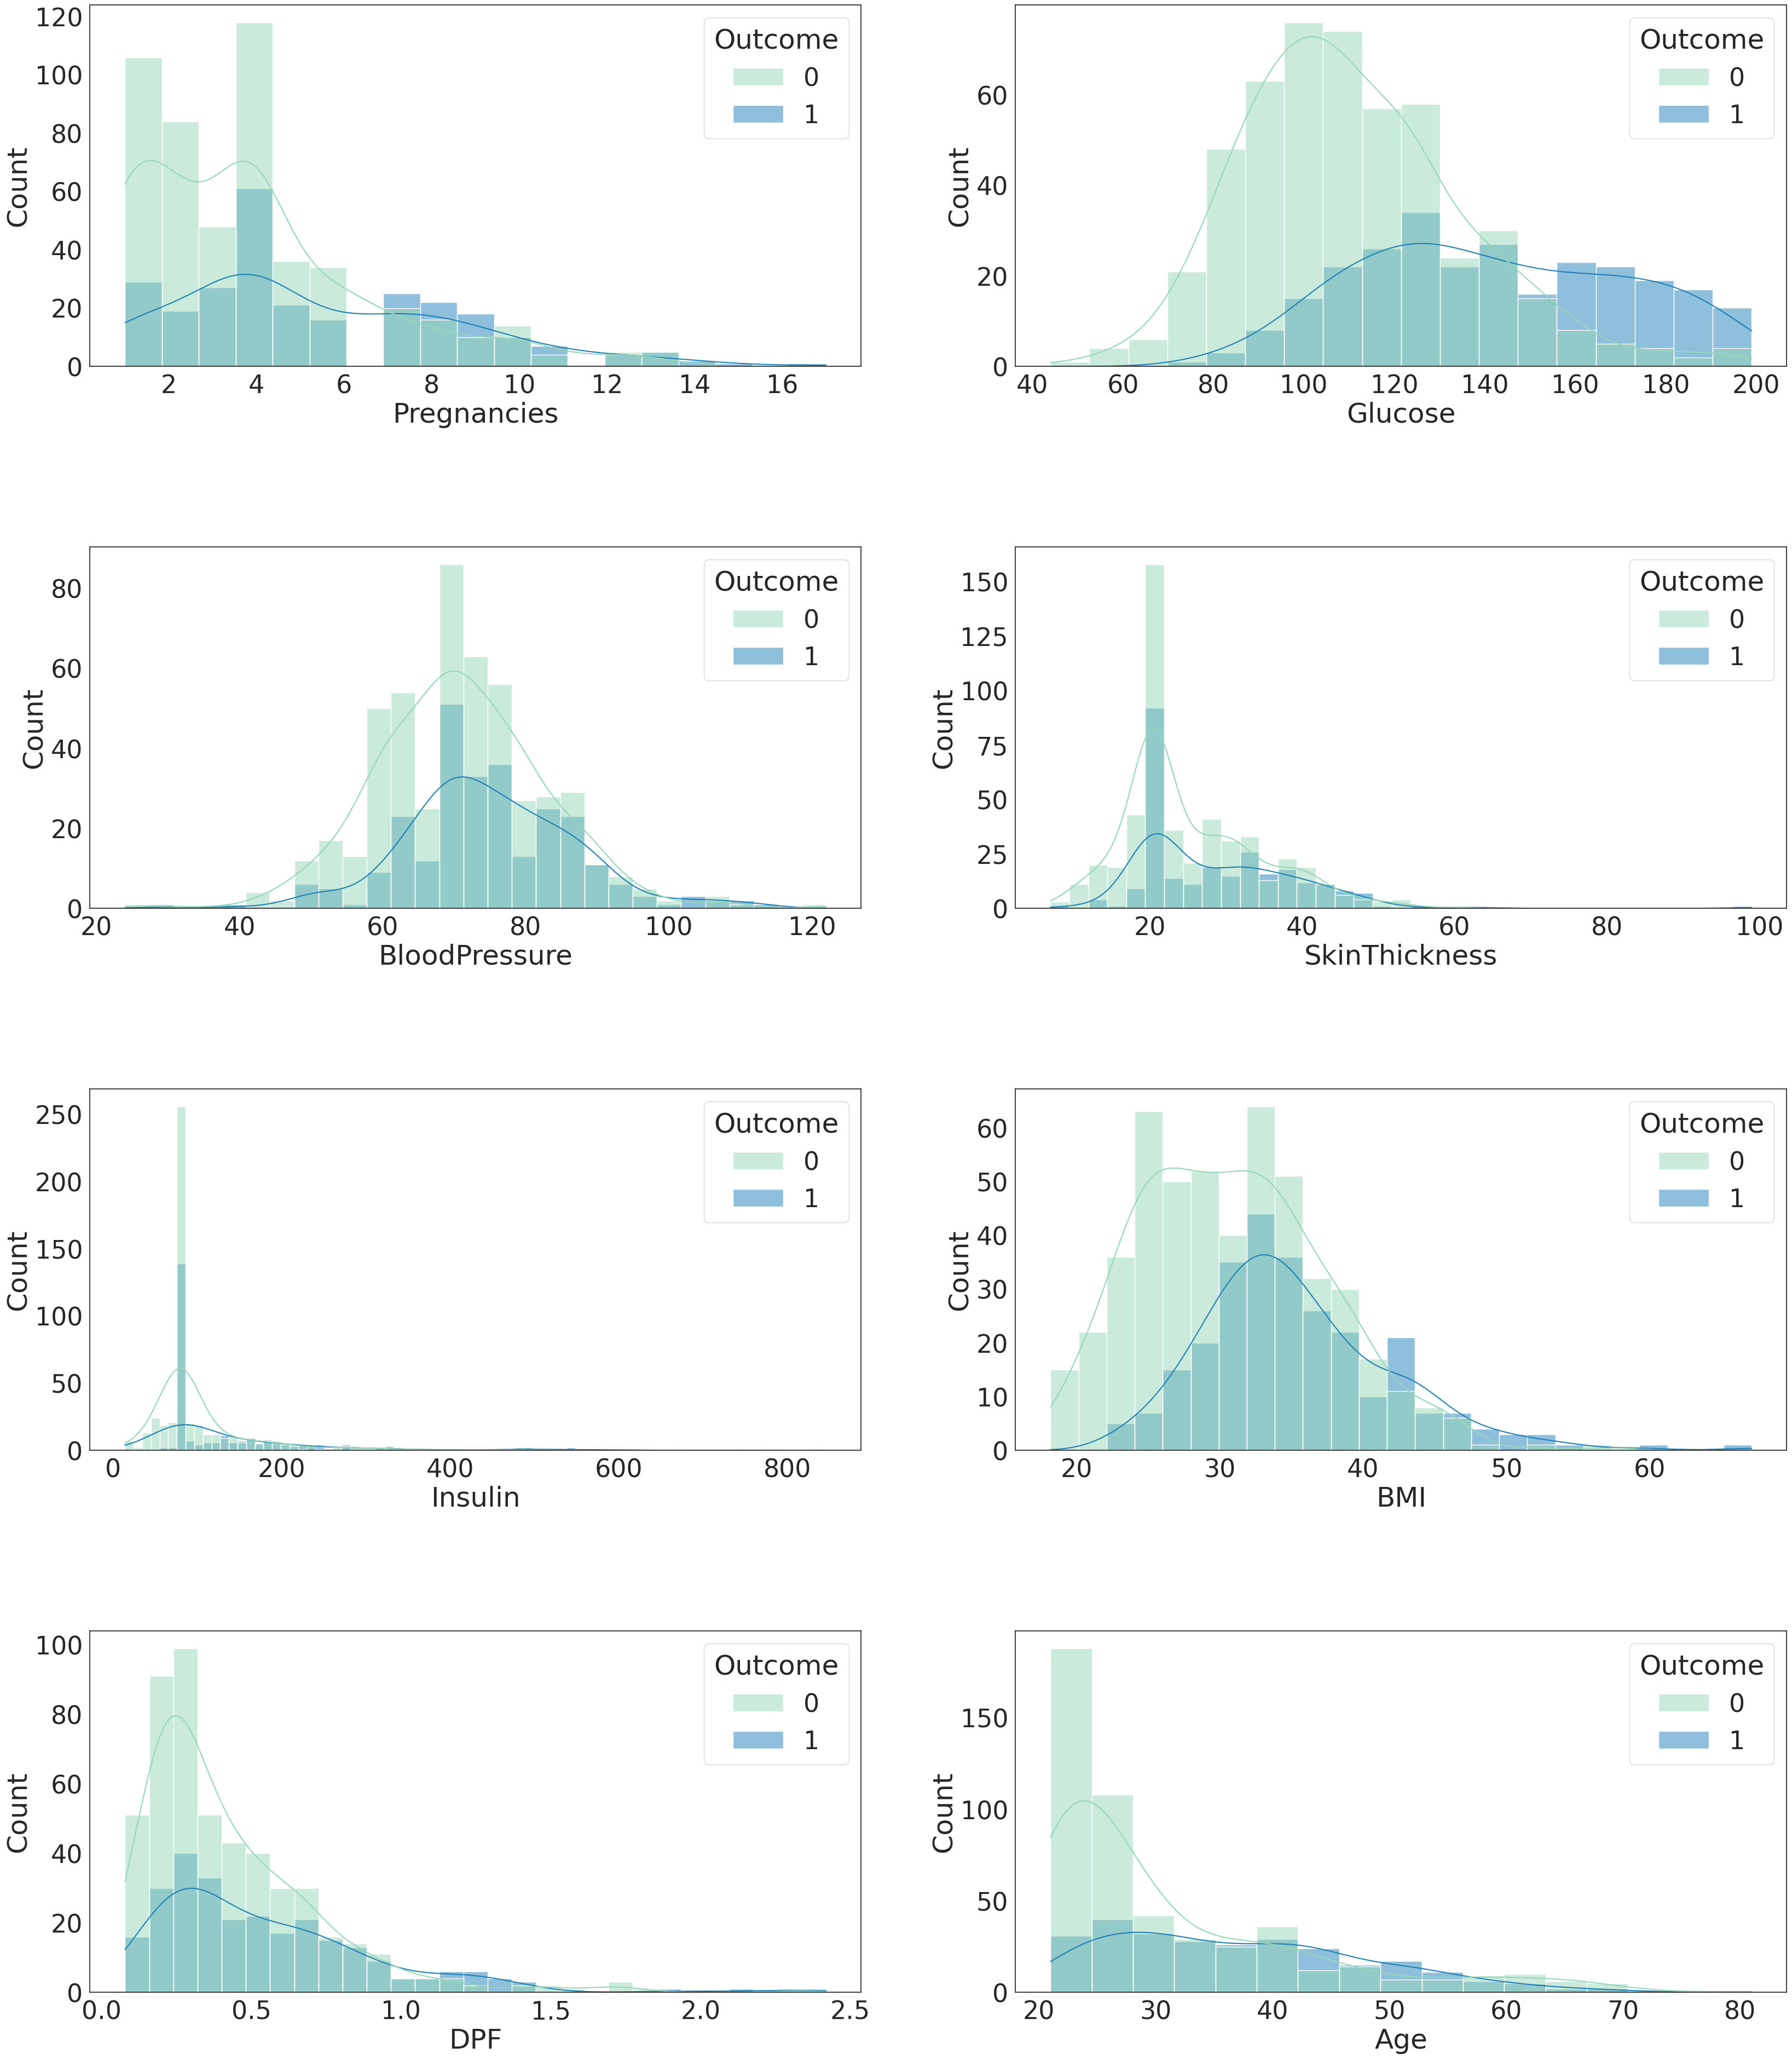

In [38]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Looking at the picture above, you can see that the zero value is removed and scaling is done. However, the shape of the distribution of Pregnancies does not look good.

# Checking correlation between features

Let's check the correlations between each variable.

Text(0.5, 1.0, 'Correlation Plot')

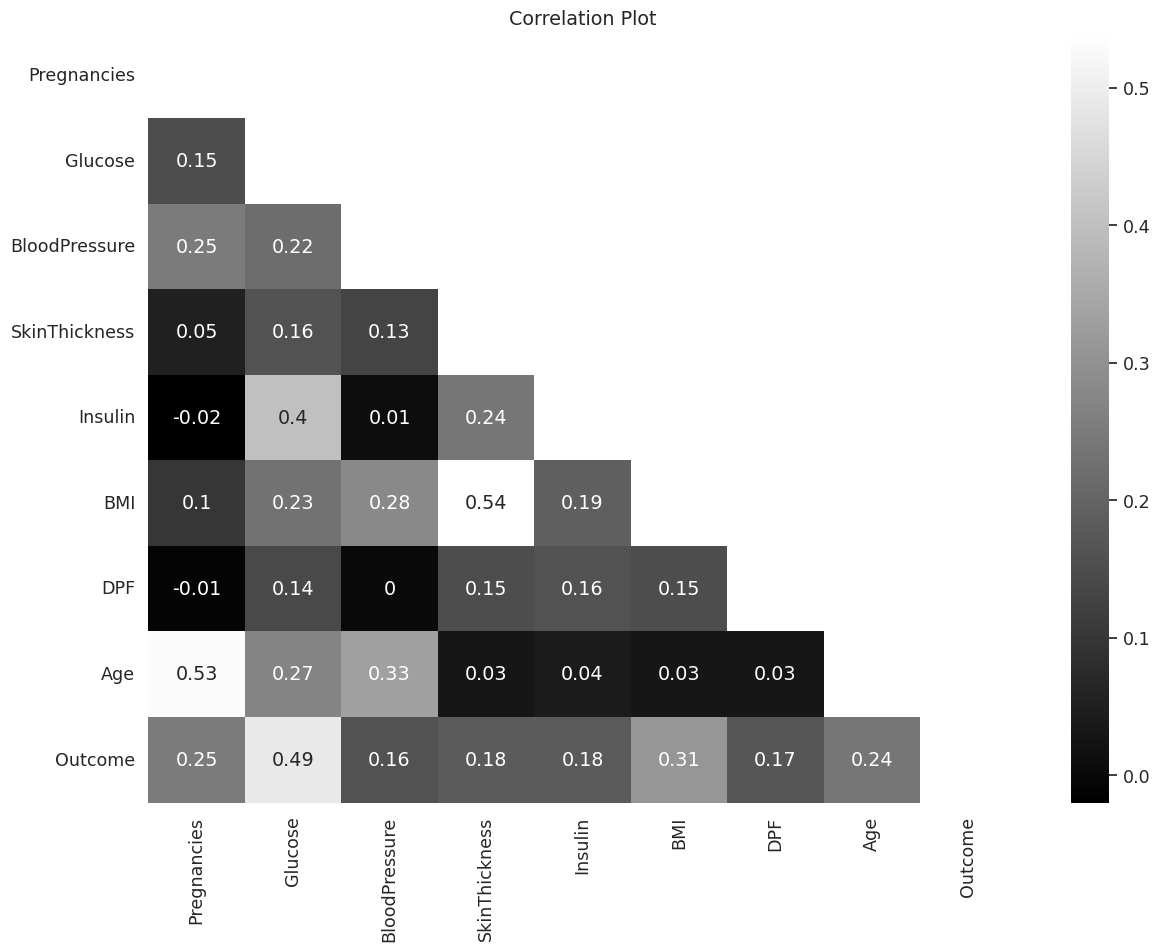

In [39]:
corr=diabetes_df.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

<Figure size 1000x800 with 0 Axes>

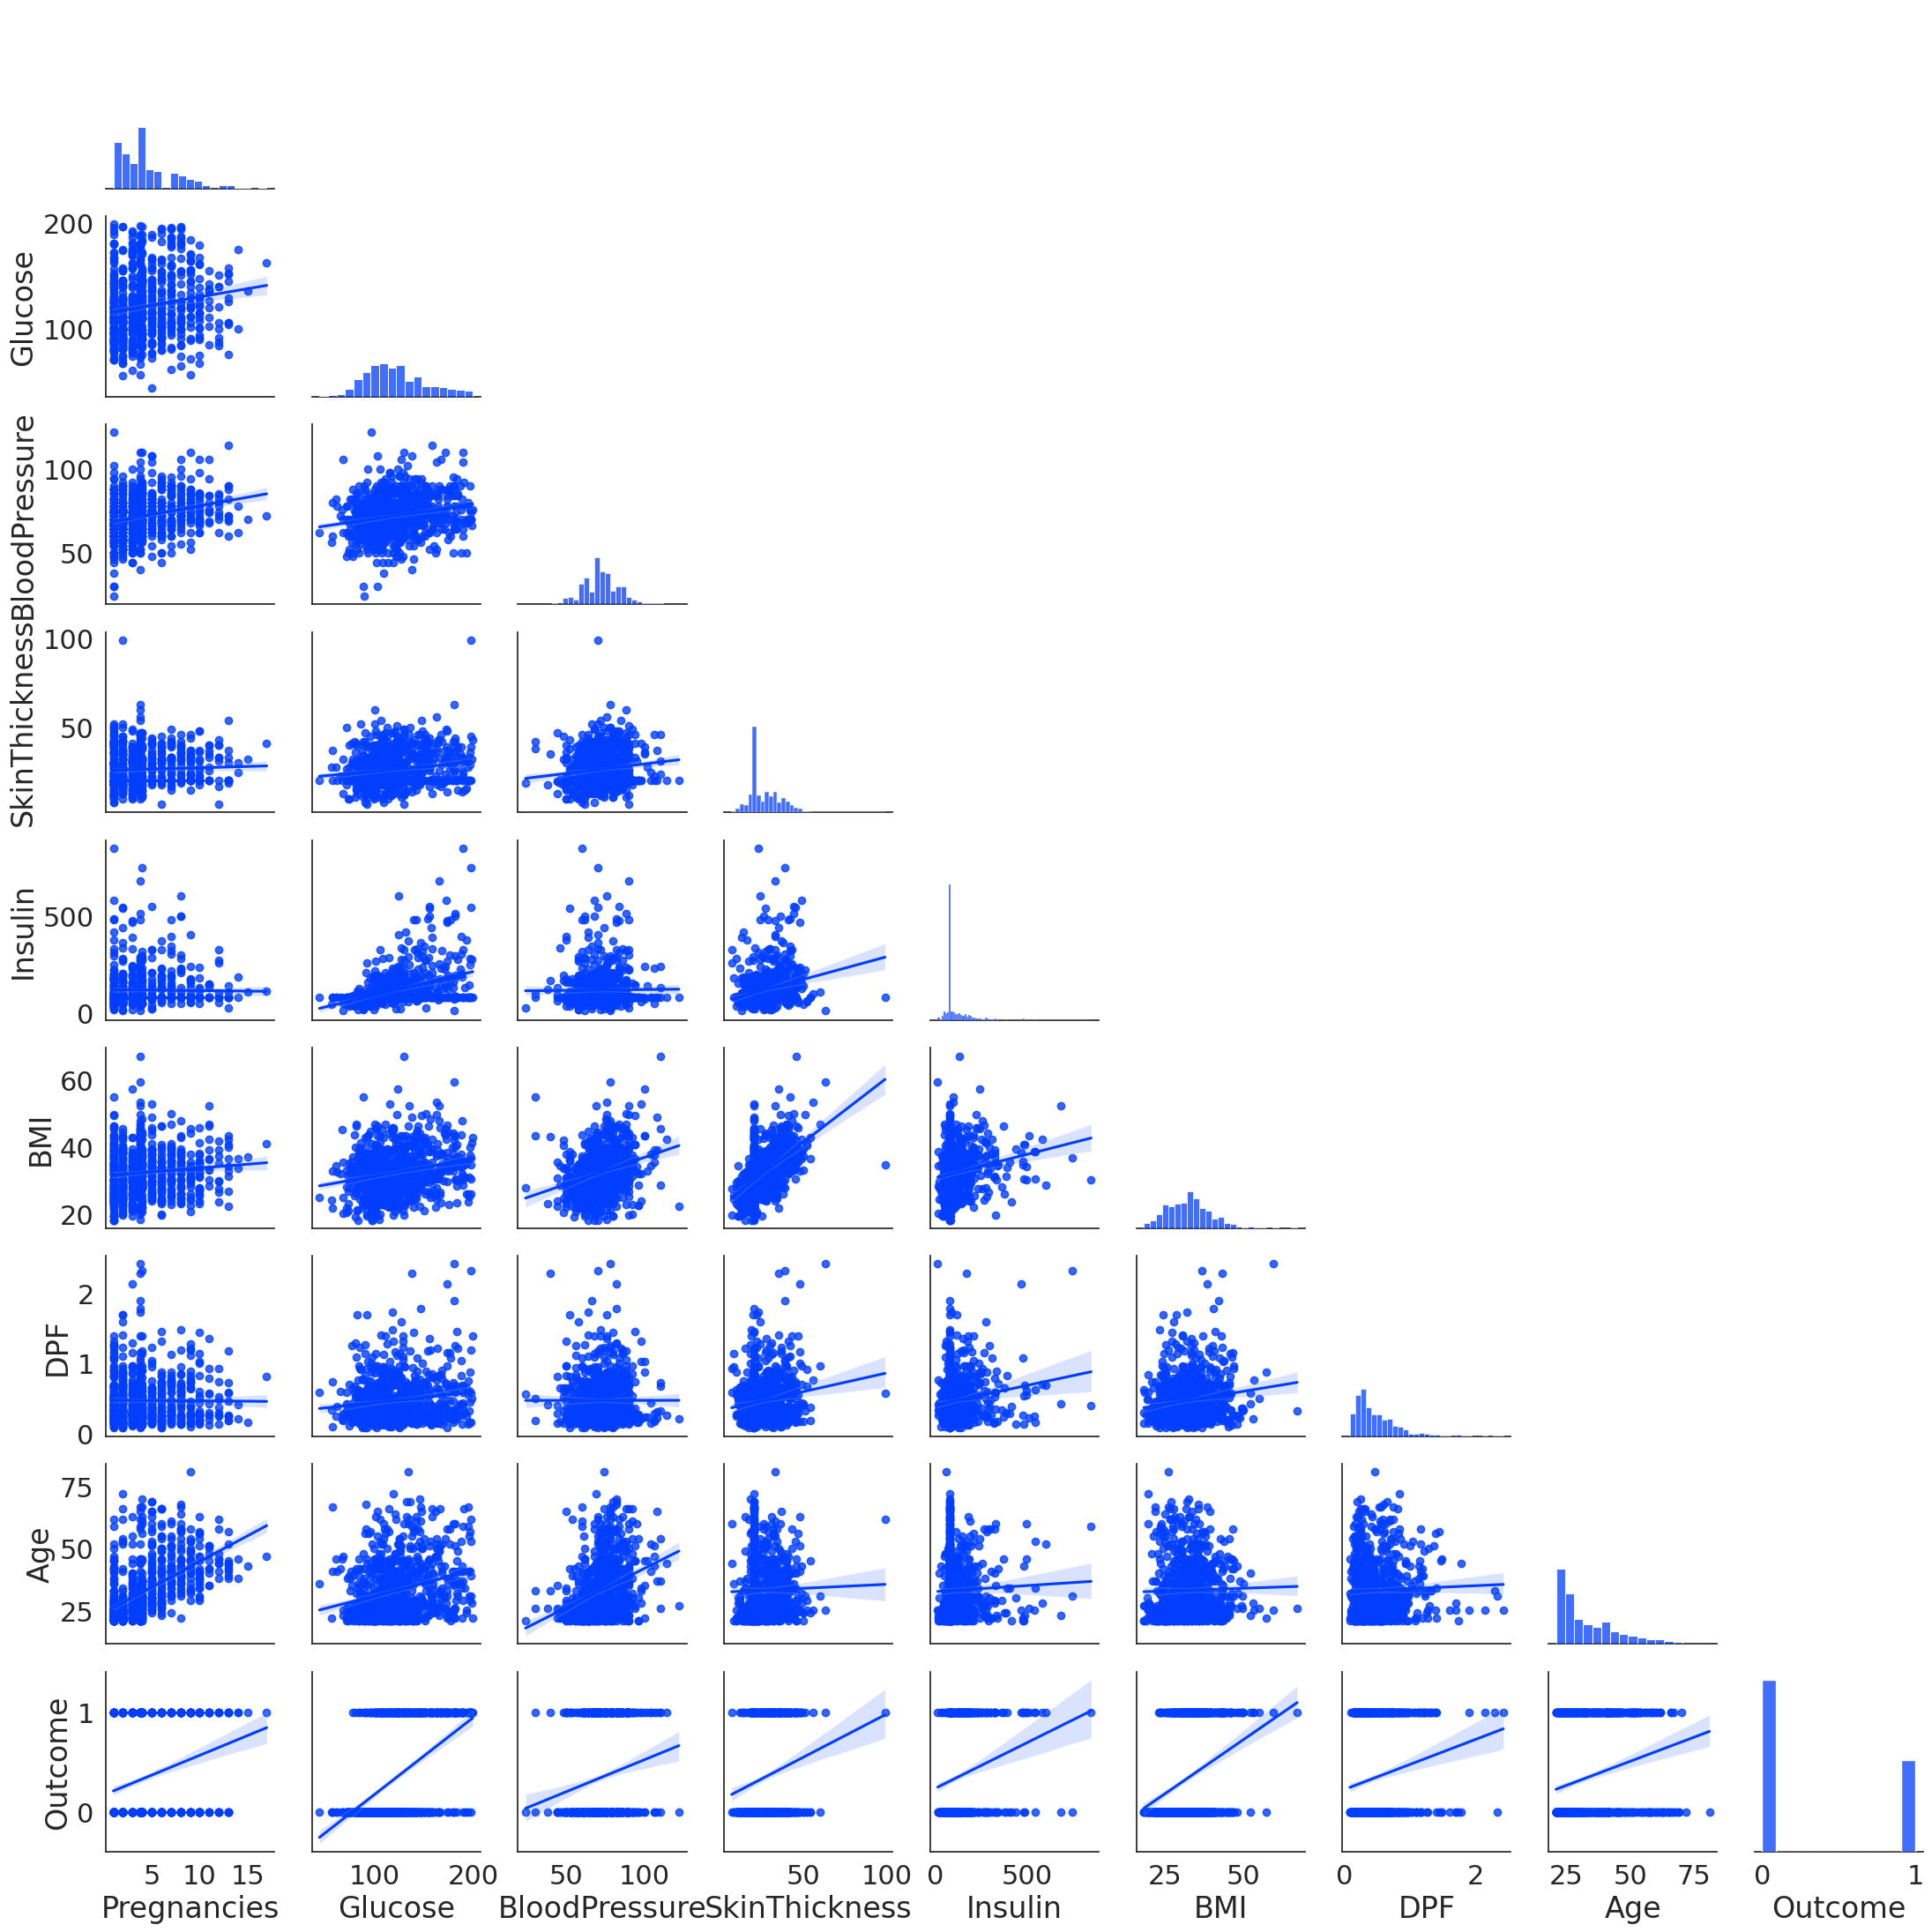

In [46]:
sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")
sns.pairplot(diabetes_df,kind = 'reg',corner = True,palette ='YlGnBu' )

<span style="color:Blue"> **Observation:**
* The correlation between Outcome and Glucose is high. Glucoe seems to be the most important feature in model training.
* BMI, Pregnancys, and Age are also expected to be used as important features in model training.
* High correlation coefficient with SkinThickness and BMI. There may be a multicollinearity problem, but if there is a performance problem after checking the result, check it again.

-----------------------------------------------
# Checking features before modeling

Looking at the figure above, the correlation coefficient between Outcome and Glucose is the highest at 0.49. Let's examine this in more depth.

In [47]:
fig = px.histogram(diabetes_df, x="Glucose",
                   color="Outcome",
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Glucose Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [48]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="BMI",
                   color="Outcome",
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "BMI Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [49]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="Age",
                   color="Outcome",
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Age Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

From the above figures, you can see what distribution each feature has for each output. In the case of glucose with high correlation, it can be seen that the distribution of outcomes 1 and 0 has a more distant shape than other features. In this case, it is expected to have a better effect on classification.

**OK! Let's make models and train it.**

----------------------------------------------------------------------------
# Visualizing Training Dataset after Dimension Reduction

In [50]:
X_train = diabetes_df.drop('Outcome',axis=1)
y_train = diabetes_df['Outcome']

In [52]:
from pycaret.classification import *

In [54]:
clf1 = setup(data = diabetes_df,
             target = 'Outcome',
             preprocess = False)

,Description,Value
0,Session id,8841
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8


In [55]:
top5 = compare_models(sort='AUC',
                      n_select = 5,
                      exclude=['lightgbm','xgboost','dummy','svm','ridge','knn','dt','nb','qda']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7654,0.8290,0.5670,0.7198,0.6192,0.4564,0.4720,0.6390
lda,Linear Discriminant Analysis,0.7597,0.8282,0.5450,0.7035,0.6077,0.4403,0.4519,0.0770
gbc,Gradient Boosting Classifier,0.7559,0.8258,0.6254,0.6660,0.6373,0.4551,0.4614,0.3350
lr,Logistic Regression,0.7635,0.8243,0.5506,0.7072,0.6137,0.4488,0.4594,0.4820
ada,Ada Boost Classifier,0.7409,0.8027,0.5933,0.6411,0.6070,0.4168,0.4239,0.2640
et,Extra Trees Classifier,0.7374,0.7988,0.5240,0.6652,0.5772,0.3923,0.4039,0.5010


Processing:   0%|          | 0/33 [00:00<?, ?it/s]

## Creating Models

This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold.


In [59]:
rf = create_model('rf')
lr = create_model('lr')
lda = create_model('lda')
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7222,0.8233,0.3684,0.7000,0.4828,0.3170,0.3476
1,0.7963,0.8105,0.6316,0.7500,0.6857,0.5367,0.5410
2,0.8148,0.8226,0.6316,0.8000,0.7059,0.5735,0.5820
3,0.7778,0.7992,0.6316,0.7059,0.6667,0.5008,0.5025
4,0.7593,0.8534,0.3684,0.8750,0.5185,0.3917,0.4569
5,0.7222,0.8669,0.6842,0.5909,0.6341,0.4122,0.4151
6,0.7593,0.8075,0.6316,0.6667,0.6486,0.4658,0.4661
7,0.7925,0.8579,0.7222,0.6842,0.7027,0.5435,0.5439
8,0.7547,0.8310,0.3889,0.7778,0.5185,0.3776,0.4184


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.8075,0.3158,0.6000,0.4138,0.2260,0.2477
1,0.7778,0.8331,0.5263,0.7692,0.6250,0.4749,0.4921
2,0.7778,0.8752,0.5263,0.7692,0.6250,0.4749,0.4921
3,0.6852,0.7835,0.4737,0.5625,0.5143,0.2839,0.2862
4,0.8148,0.8436,0.6316,0.8000,0.7059,0.5735,0.5820
5,0.7963,0.8662,0.7895,0.6818,0.7317,0.5689,0.5729
6,0.8333,0.8526,0.6316,0.8571,0.7273,0.6112,0.6260
7,0.7358,0.7984,0.5556,0.6250,0.5882,0.3948,0.3963
8,0.7736,0.7778,0.5556,0.7143,0.6250,0.4664,0.4740


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.8165,0.3158,0.6000,0.4138,0.2260,0.2477
1,0.7963,0.8376,0.5263,0.8333,0.6452,0.5123,0.5389
2,0.7778,0.8752,0.5263,0.7692,0.6250,0.4749,0.4921
3,0.6852,0.7835,0.4737,0.5625,0.5143,0.2839,0.2862
4,0.8148,0.8451,0.6316,0.8000,0.7059,0.5735,0.5820
5,0.7778,0.8707,0.7895,0.6522,0.7143,0.5352,0.5417
6,0.8333,0.8602,0.6316,0.8571,0.7273,0.6112,0.6260
7,0.7358,0.8032,0.5556,0.6250,0.5882,0.3948,0.3963
8,0.7547,0.7857,0.5000,0.6923,0.5806,0.4136,0.4246


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7037,0.8060,0.4211,0.6154,0.5000,0.2998,0.3107
1,0.7407,0.8376,0.6316,0.6316,0.6316,0.4316,0.4316
2,0.7778,0.8000,0.6316,0.7059,0.6667,0.5008,0.5025
3,0.7963,0.8526,0.7368,0.7000,0.7179,0.5587,0.5591
4,0.8148,0.8436,0.5263,0.9091,0.6667,0.5507,0.5902
5,0.7778,0.8947,0.7368,0.6667,0.7000,0.5242,0.5259
6,0.7778,0.8301,0.7368,0.6667,0.7000,0.5242,0.5259
7,0.7358,0.8317,0.6111,0.6111,0.6111,0.4111,0.4111
8,0.6981,0.7984,0.5000,0.5625,0.5294,0.3083,0.3095


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## Interpreting Models

In [61]:
interpret_model(rf)

ModuleNotFoundError: ignored

<span style="color:Blue"> **Observation:**
* As expected, glucose is used as the most important feature.
* SkinTickness and BloodPressure have the low importance.

Let's compare the feature importance of the above two models. A comparison was made with SHAP values, and the feature importance of each model is slightly different.
The diversity of each model seems to be stable and improve performance while compensating for each other's weaknesses.

If you are more interested in feature importance, please refer to the notebook below.

[Notebook](https://www.kaggle.com/ohseokkim/interpreting-models-by-feature-importnace)

# Tuning Hyperparameters

> This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter.

In [62]:
tuned_rf = tune_model(rf, optimize = 'AUC')
tuned_lr = tune_model(lr, optimize = 'AUC')
tuned_lda = tune_model(lda, optimize = 'AUC')
tuned_gbc = tune_model(gbc, optimize = 'AUC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,04:36:45
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7222,0.7805,0.6316,0.6000,0.6154,0.3982,0.3985
1,0.7222,0.8466,0.6316,0.6000,0.6154,0.3982,0.3985
2,0.8148,0.8511,0.8421,0.6957,0.7619,0.6126,0.6201
3,0.6667,0.7970,0.6842,0.5200,0.5909,0.3184,0.3269
4,0.7407,0.8256,0.6316,0.6316,0.6316,0.4316,0.4316
5,0.7778,0.8586,0.8421,0.6400,0.7273,0.5456,0.5602
6,0.7778,0.8316,0.7895,0.6522,0.7143,0.5352,0.5417
7,0.7547,0.8365,0.8333,0.6000,0.6977,0.5004,0.5195
8,0.7925,0.8079,0.7222,0.6842,0.7027,0.5435,0.5439


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7037,0.8105,0.4737,0.6000,0.5294,0.3175,0.3223
1,0.7222,0.8346,0.6316,0.6000,0.6154,0.3982,0.3985
2,0.8333,0.8752,0.7368,0.7778,0.7568,0.6301,0.6307
3,0.7593,0.7850,0.8421,0.6154,0.7111,0.5132,0.5318
4,0.8148,0.8451,0.7368,0.7368,0.7368,0.5940,0.5940
5,0.7407,0.8677,0.7895,0.6000,0.6818,0.4698,0.4825
6,0.7407,0.8511,0.7368,0.6087,0.6667,0.4577,0.4633
7,0.6981,0.8048,0.7222,0.5417,0.6190,0.3774,0.3881
8,0.7736,0.7730,0.6111,0.6875,0.6471,0.4812,0.4830


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.8135,0.3158,0.6000,0.4138,0.2260,0.2477
1,0.7778,0.8436,0.5263,0.7692,0.6250,0.4749,0.4921
2,0.7778,0.8782,0.5263,0.7692,0.6250,0.4749,0.4921
3,0.7037,0.7835,0.4737,0.6000,0.5294,0.3175,0.3223
4,0.7963,0.8391,0.6316,0.7500,0.6857,0.5367,0.5410
5,0.7778,0.8617,0.7895,0.6522,0.7143,0.5352,0.5417
6,0.7963,0.8466,0.6316,0.7500,0.6857,0.5367,0.5410
7,0.7358,0.8032,0.6111,0.6111,0.6111,0.4111,0.4111
8,0.7547,0.7889,0.5000,0.6923,0.5806,0.4136,0.4246


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6481,0.8241,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6481,0.8376,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6481,0.8466,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6481,0.8241,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6481,0.8842,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6481,0.8752,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6481,0.8481,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.6604,0.8619,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.6604,0.7698,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits



Top 1, Top 2, Top 3 ,Top 4, and Top 5 models were tuned with different feature importance and decision boundary. Also, there is a big difference in feature importance from the catboost classifier.

-----------------------------------------------------------------------------------------------------------------------------------------
# Stacking

![](https://miro.medium.com/max/1000/1*CoauXirckomVXxw2Id2w_Q.jpeg)



In [63]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6296,0.7782,0.2105,0.4444,0.2857,0.0769,0.0867
1,0.7593,0.8586,0.5789,0.6875,0.6286,0.4524,0.4561
2,0.8333,0.8233,0.6316,0.8571,0.7273,0.6112,0.6260
3,0.7407,0.8000,0.6316,0.6316,0.6316,0.4316,0.4316
4,0.7778,0.8331,0.5263,0.7692,0.6250,0.4749,0.4921
5,0.8148,0.8887,0.7895,0.7143,0.7500,0.6035,0.6054
6,0.8148,0.8474,0.7368,0.7368,0.7368,0.5940,0.5940
7,0.7358,0.8254,0.6667,0.6000,0.6316,0.4266,0.4280
8,0.7547,0.7905,0.5000,0.6923,0.5806,0.4136,0.4246


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

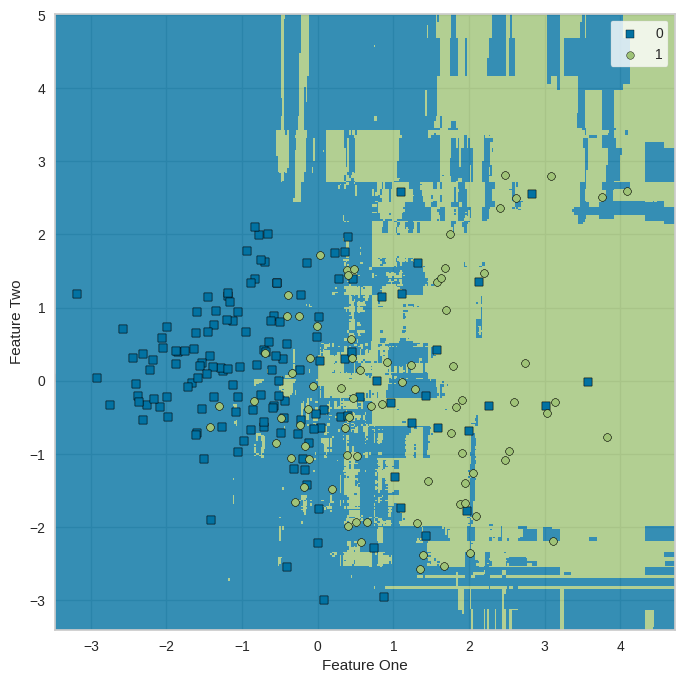

In [64]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='boundary')

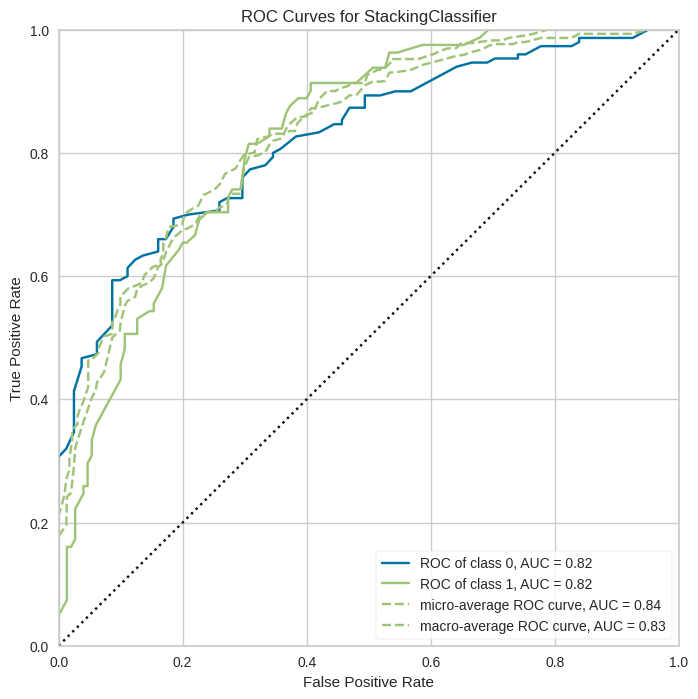

In [65]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot = 'auc')

In [66]:
#prediction
pred = stack_model.predict(X_test)
pred_proba = stack_model.predict_proba(X_test)[:,1]
#Accuracy
confusion_stack = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.8385, precision: 0.7794, recall: 0.7681,    F1: 0.7737, AUC:0.9100


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

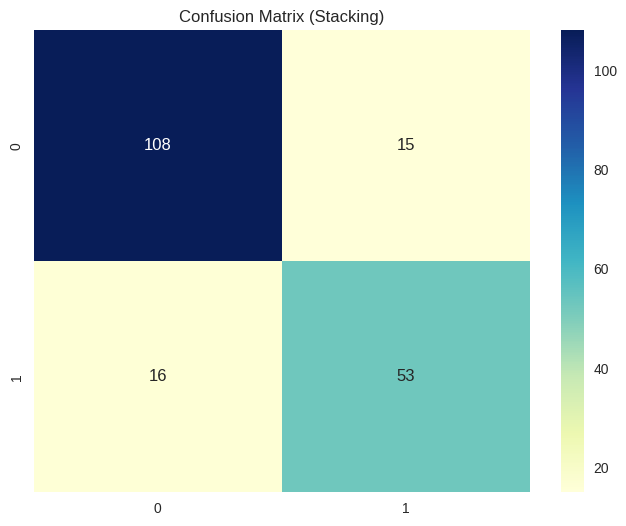

In [67]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_stack, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

Precision and recall have a trade-off relationship. The picture above seems to be well balanced because it has been studied well.

In [68]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7222,0.8286,0.4211,0.6667,0.5161,0.3350,0.3524
1,0.7407,0.8556,0.5263,0.6667,0.5882,0.4028,0.4088
2,0.7778,0.8571,0.5263,0.7692,0.6250,0.4749,0.4921
3,0.7407,0.8135,0.6316,0.6316,0.6316,0.4316,0.4316
4,0.8148,0.8752,0.5789,0.8462,0.6875,0.5624,0.5828
5,0.7778,0.8857,0.7368,0.6667,0.7000,0.5242,0.5259
6,0.8148,0.8331,0.6842,0.7647,0.7222,0.5840,0.5860
7,0.7736,0.8349,0.6667,0.6667,0.6667,0.4952,0.4952
8,0.7547,0.8143,0.4444,0.7273,0.5517,0.3961,0.4189


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

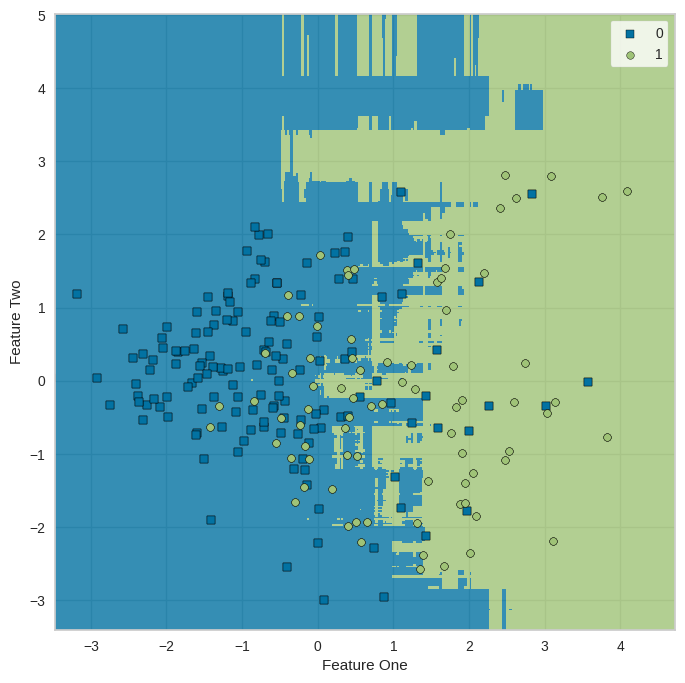

In [69]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot='boundary')

It looks like the model has been properly trained.

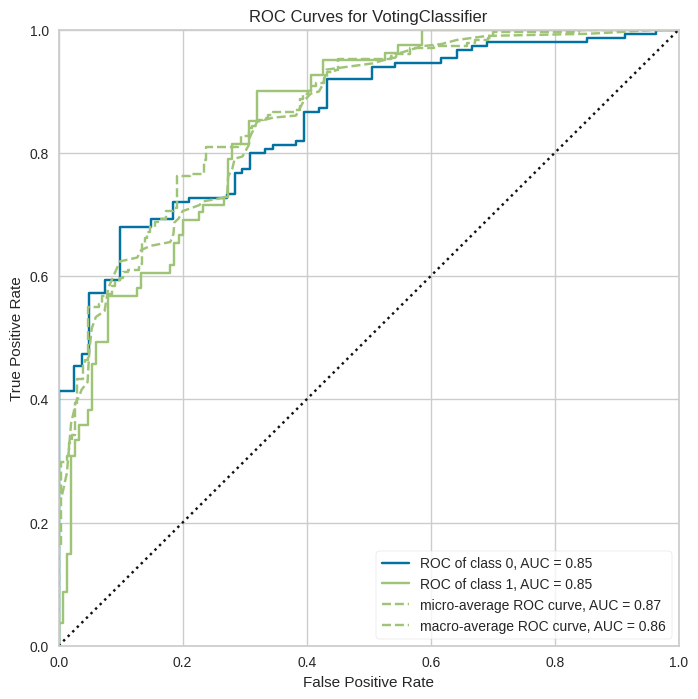

In [70]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot = 'auc')

In [71]:
#prediction
pred = blend_soft.predict(X_test)
pred_proba = blend_soft.predict_proba(X_test)[:,1]
#Accuracy
confusion_soft = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.8490, precision: 0.8125, recall: 0.7536,    F1: 0.7820, AUC:0.9219


Text(0.5, 1.0, 'Confusion Matrix (Soft Blending)')

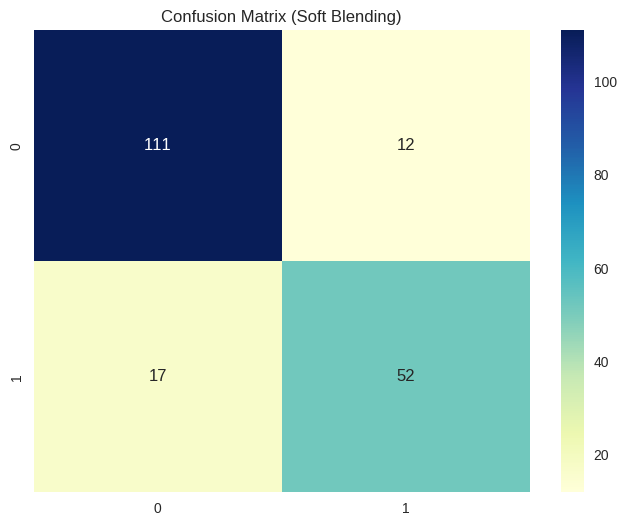

In [72]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_soft, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Soft Blending)')

The confusion matrix is ​​also well balanced and the results are good.

In [73]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7037,0.0000,0.3684,0.6364,0.4667,0.2812,0.3013
1,0.7778,0.0000,0.5789,0.7333,0.6471,0.4882,0.4954
2,0.7963,0.0000,0.5789,0.7857,0.6667,0.5248,0.5375
3,0.7593,0.0000,0.6316,0.6667,0.6486,0.4658,0.4661
4,0.8148,0.0000,0.5263,0.9091,0.6667,0.5507,0.5902
5,0.7593,0.0000,0.7368,0.6364,0.6829,0.4906,0.4940
6,0.7963,0.0000,0.6842,0.7222,0.7027,0.5479,0.5484
7,0.7547,0.0000,0.6111,0.6471,0.6286,0.4457,0.4461
8,0.7358,0.0000,0.4444,0.6667,0.5333,0.3592,0.3736


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

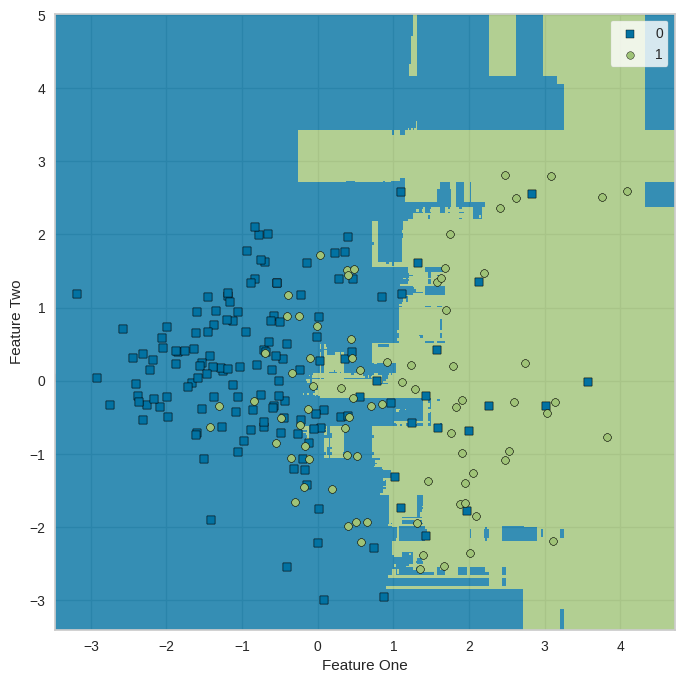

In [74]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='boundary')

It seems to have been well learned.

# Predicting with the test dateset

In [75]:
#prediction
pred = blend_hard.predict(X_test)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred)
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8542, precision: 0.8060, recall: 0.7826,F1: 0.7941


Text(0.5, 1.0, 'Confusion Matrix (Hard Blending)')

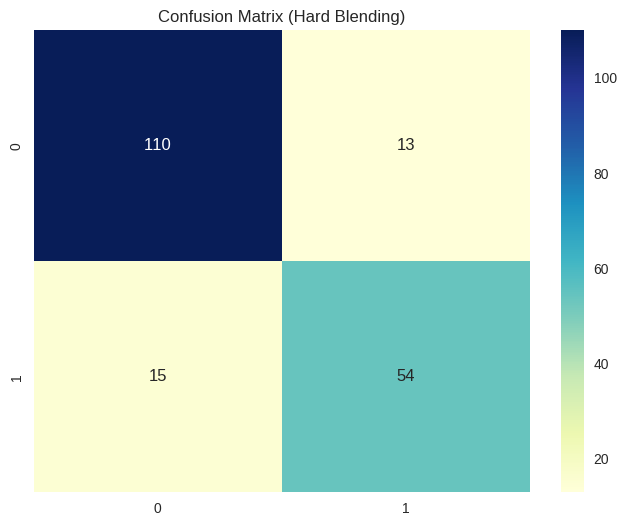

In [76]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

-----------------------------------------------
# Calibrating the final model

This function calibrates the probability of a given estimator using isotonic or logistic regression.


In [77]:
cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.8286,0.3158,0.6000,0.4138,0.2260,0.2477
1,0.7593,0.8436,0.5263,0.7143,0.6061,0.4384,0.4490
2,0.7778,0.8586,0.5263,0.7692,0.6250,0.4749,0.4921
3,0.7407,0.8105,0.6316,0.6316,0.6316,0.4316,0.4316
4,0.8148,0.8617,0.5789,0.8462,0.6875,0.5624,0.5828
5,0.7778,0.8782,0.7368,0.6667,0.7000,0.5242,0.5259
6,0.8148,0.8376,0.6842,0.7647,0.7222,0.5840,0.5860
7,0.7358,0.8270,0.6111,0.6111,0.6111,0.4111,0.4111
8,0.7547,0.8063,0.4444,0.7273,0.5517,0.3961,0.4189


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

----------------------------------------------
# Finalizing the last model

This function trains a given estimator on the entire dataset including the holdout set.


In [78]:
final_model = finalize_model(cali_model)

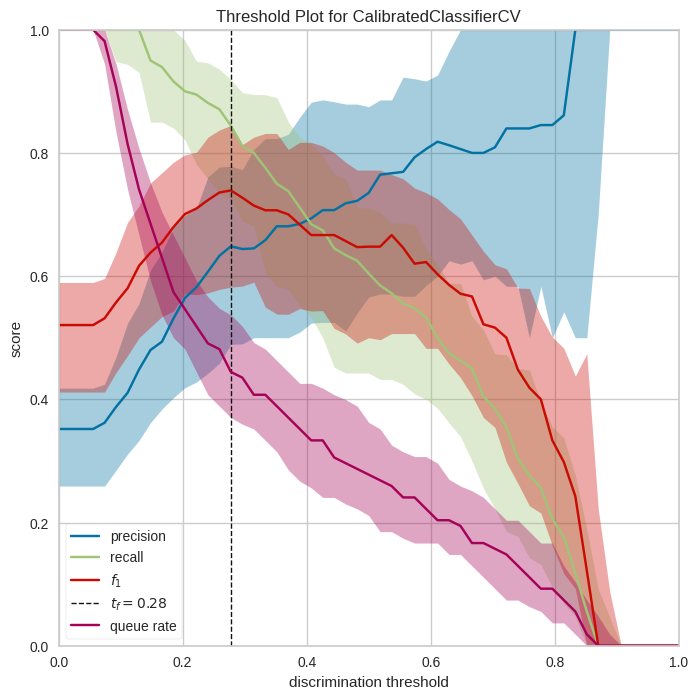

In [79]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='threshold')

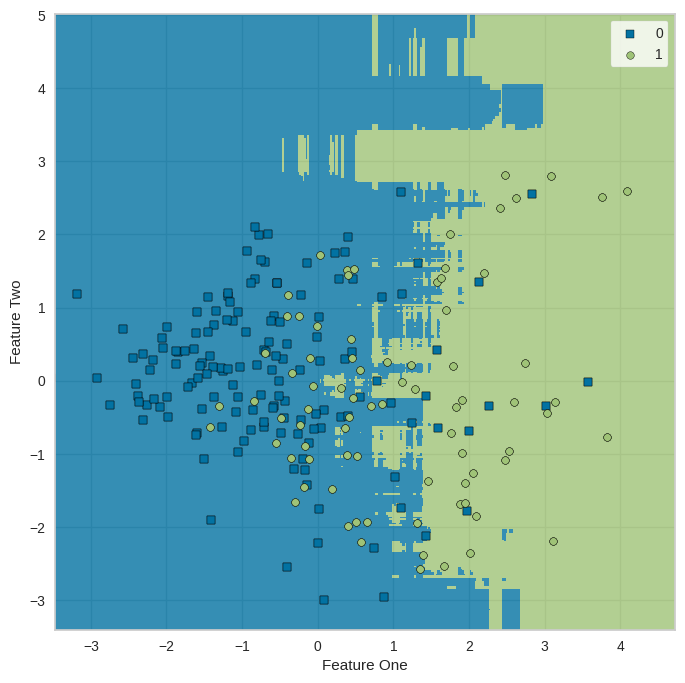

In [80]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='boundary')

In [81]:
#prediction
pred = final_model.predict(X_test)
#Accuracy
final_model = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred)
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8438, precision: 0.8421, recall: 0.6957,F1: 0.7619


Text(0.5, 1.0, 'Confusion Matrix (final_model)')

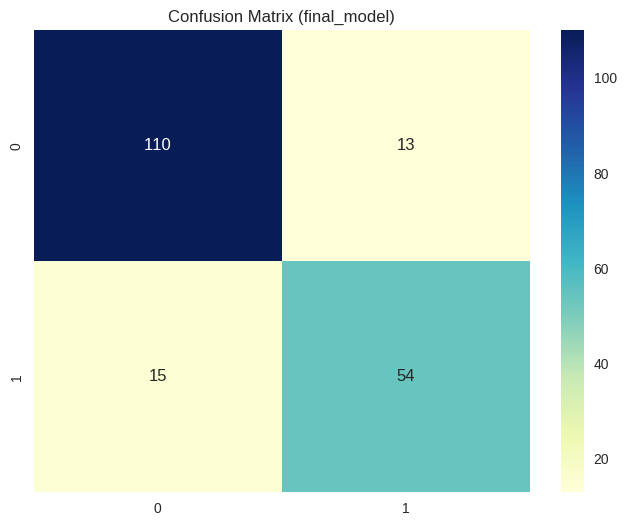

In [82]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')

<hr style="border: solid 3px blue;">

# Conclusion

**After EDA and preprocessing, three ensamble models were run and the performance was verified with the validation dataset. Ensamble using soft and hard voting gave the best result in solving this problem, but different results may come out depending on preprocessing and selection of base models and hyperparameter settings.**